In [169]:
# pip install tensorflow

In [170]:
# pip install --upgrade tensorflow

In [171]:
# pip install keras

In [172]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Setting the random seed to be used for all modeling steps
tf.keras.utils.set_random_seed(42)

In [173]:
# Document Python version
from watermark import watermark

print(watermark())

Last updated: 2023-10-20T00:58:16.645960-04:00

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.34.0

Compiler    : MSC v.1900 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [174]:
# df_MMRT = pd.read_csv('WorldBankDatasets/Cleaned/AllMerged_Threshold_85_n3_MMRT.csv')

df_MMRTNE = pd.read_csv(
    "../WorldBankDatasets/Cleaned/AllMerged_Threshold_85_n3_MMRTNE.csv"
)
df_OECD = pd.read_csv("../OECD/Cleaned/HEALTH_MERGED_Threshold_80_n3.csv")

In [175]:
# select which df to use

df = df_MMRTNE
indicator_y = "SH.STA.MMRT.NE"

# df = df_MMRT
# indicator_y = 'SH.STA.MMRT'

# df = df_OECD
# indicator_y = 'MATIMATM'

# Perform hyper parameter tuning?
perform_hp_tuning = False

In [176]:
# First need to encode the country

# Create a LabelEncoder instance for each categorical column
country_encoder = LabelEncoder()

# Encode the categorical columns
data_encoded = df.copy()
data_encoded["Country"] = country_encoder.fit_transform(data_encoded["Country"])

In [177]:
# pull out Maternal Mortality as the predictor variable
X = data_encoded.drop(columns=indicator_y)
y = data_encoded[indicator_y]

In [178]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [179]:
X_dev, X_test, y_dev, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42
)

### Define the model and hyper-parameters

In [180]:
def build_model(learning_rate, num_hidden_units, batch_size):
    model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(
                input_shape=X.shape[1],
            ),
            tf.keras.layers.Dense(num_hidden_units, activation="relu"),
            tf.keras.layers.Dense(num_hidden_units, activation="relu"),
            tf.keras.layers.Dense(1),  # Output layer for regression
        ]
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.compile(loss="huber_loss", optimizer=optimizer)
    return model

In [181]:
### Set up hyper-parameter tuning - set to False to not compute!!

if perform_hp_tuning:
    # Paramters to sweep over
    param_dist = {
        "learning_rate": [
            0.001
        ],  # , 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1], # Higher values like 0.06 produce issues as noted below
        "num_hidden_units": [64, 128, 256],
        "batch_size": [32, 64, 128],
    }

    # Establish the model
    model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn=build_model)

    # Perform grid search over all parameters in param_dist
    search = GridSearchCV(
        estimator=model, param_grid=param_dist, scoring="r2", cv=5, verbose=0
    )
    search.fit(X_train, y_train, verbose=0)

    # Store the best parameters for building the final model
    best_params = search.best_params_
    best_learning_rate = best_params["learning_rate"]
    best_num_hidden_units = best_params["num_hidden_units"]
    best_batch_size = best_params["batch_size"]

    # Print parameter values
    print(f"Best Learning Rate: {best_learning_rate}")
    print(f"Best Number of Hidden Units: {best_num_hidden_units}")
    print(f"Best Batch Size: {best_batch_size}")

else:
    # Take the values found from the previous hyperparameter tuning step

    if indicator_y == "MATIMATM":  # OECD data is being modeled
        best_learning_rate = 0.001  # Hyperparameter tuning actually found 0.06 but this produces only 1 prediction for all points
        best_num_hidden_units = 64
        best_batch_size = 64

    elif indicator_y == "SH.STA.MMRT.NE":  # World Bank Data is being modeled
        best_learning_rate = 0.001  # Hyperparameter tuning actually found 0.06 but this produces only 1 prediction for all points
        best_num_hidden_units = 128
        best_batch_size = 32

### Build Single Model

In [182]:
# Build the model with the values found from hyperparameter tuning
best_model = build_model(best_learning_rate, best_num_hidden_units, best_batch_size)

In [183]:
# Define the number of epochs
num_epochs = 400

# Initialize lists to store training history
loss_history = []
val_loss_history = []

for epoch in tqdm(range(num_epochs), desc="Training"):
    history = best_model.fit(
        X_train,
        y_train,
        epochs=1,
        batch_size=best_batch_size,
        verbose=0,
        validation_data=(X_dev, y_dev),
    )

    # Collect training history for plotting
    loss_history.append(history.history["loss"][0])

    # Collect validation loss from the history
    val_loss = history.history.get("val_loss")
    if val_loss is not None:
        val_loss_history.append(val_loss[0])
    else:
        val_loss_history.append(0)  # In case validation loss is not available

Training: 100%|██████████| 400/400 [01:03<00:00,  6.31it/s]


c:\MADS_MilestoneII\.venv\lib\site-packages\ipykernel_launcher.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  


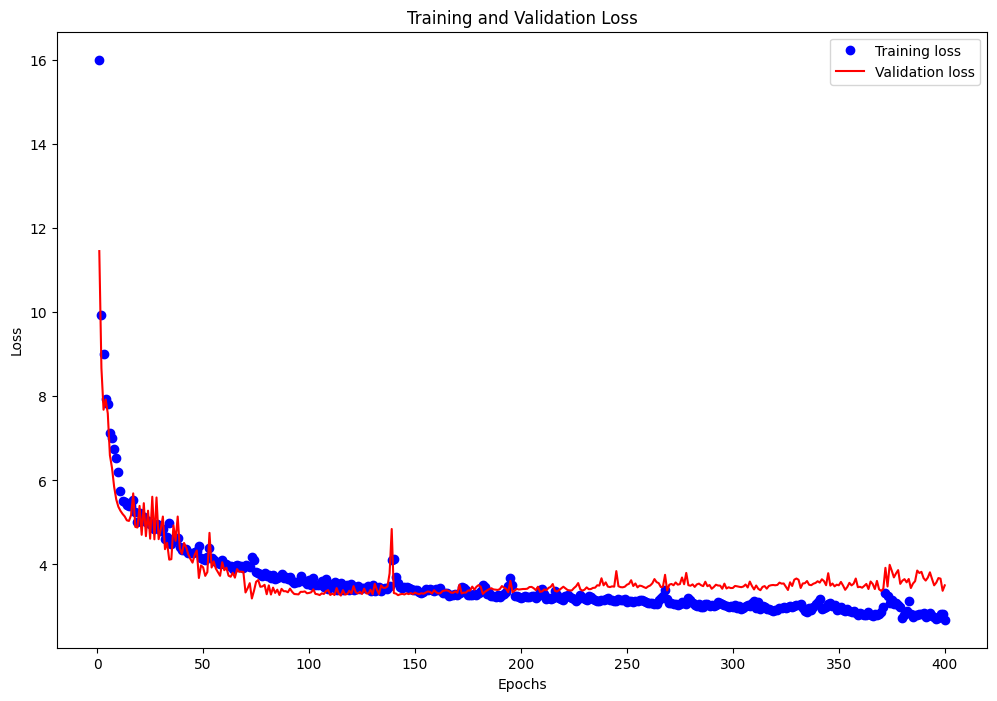

In [184]:
# Plot the training curve
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, loss_history, "bo", label="Training loss")
plt.plot(epochs, val_loss_history, "b", label="Validation loss", color="r")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

c:\MADS_MilestoneII\.venv\lib\site-packages\ipykernel_launcher.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


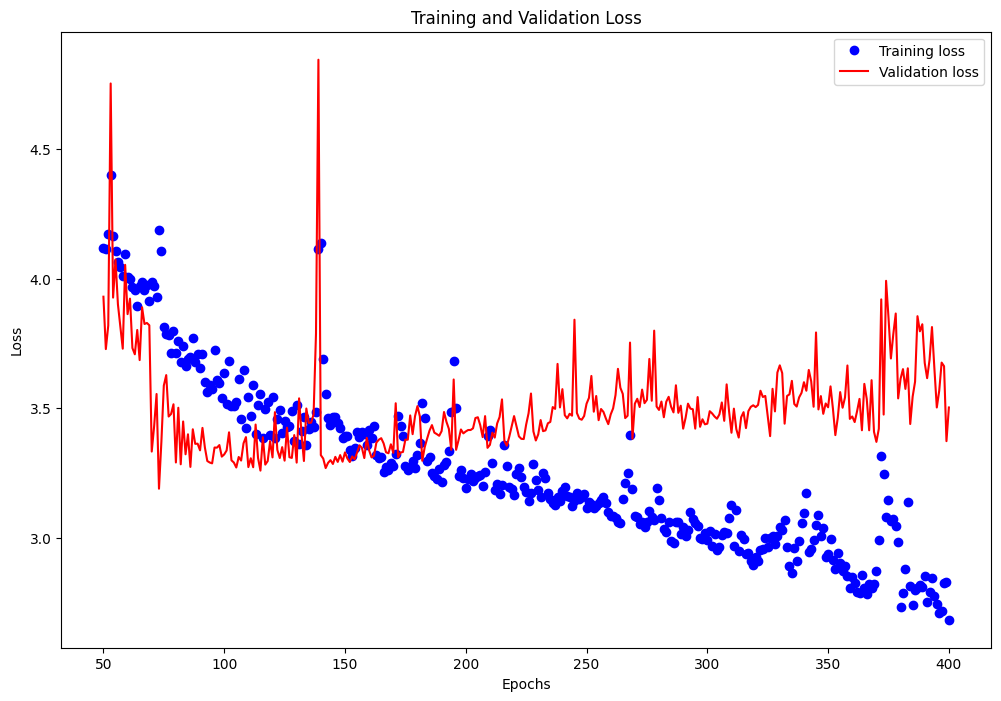

In [185]:
# Zoom in on the learning curve

# Specify the starting epoch (e.g., 3rd epoch)
start_epoch = 50

# Plot the training curve from the 3rd epoch onward
plt.figure(figsize=(12, 8))
plt.plot(
    epochs[start_epoch - 1 :],
    loss_history[start_epoch - 1 :],
    "bo",
    label="Training loss",
)
plt.plot(
    epochs[start_epoch - 1 :],
    val_loss_history[start_epoch - 1 :],
    "b",
    label="Validation loss",
    color="r",
)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [186]:
loss_train = best_model.evaluate(X_train, y_train)
loss_test = best_model.evaluate(X_test, y_test)
print(f"Mean Absolute Error on Training Data: {loss_train}")
print(f"Mean Absolute Error on Test Data: {loss_test}")

4/4 [==============================] - 0s 1ms/step - loss: 2.5018
Mean Absolute Error on Training Data: 2.6531670093536377
Mean Absolute Error on Test Data: 2.501762628555298


In [187]:
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

4/4 [==============================] - 0s 1ms/step
Mean Squared Error (MSE): 19.51864271581325
R-squared (R2): 0.9106270276173967


### Looking into the model performance

In [188]:
def plot_regression(X, y, yp, country, title):
    # X - X_test
    # y - y_test
    # yp - y_pred
    # country - list of country abbreviations ie. ['USA']

    if country == None:
        # Plot the data points and the regression line
        plt.figure(figsize=(30, 20))
        plt.scatter(X["Year"], y, color="blue", label="Data")
        plt.scatter(X["Year"], yp, color="red", label="Linear Regression")
        plt.xlabel("Year")
        plt.ylabel("Maternal Mortality Ratio")
        plt.title(title)
        plt.legend()
        plt.figure(figsize=(30, 20))
        plt.show()

    else:
        # Country encoding
        encoded_values = country_encoder.transform(country)
        # looking at just the secific country predictions in test partition

        # Use boolean indexing to select the subset of the DataFrame
        condition = X["Country"].isin(encoded_values)
        X_test = X[condition]["Year"]
        y_test = y.loc[X_test.index]

        # take the array index in order to pull the relevant y_pred
        index_positions = [y.index.get_loc(index) for index in X_test.index]

        y_pred = [yp[i] for i in index_positions]

        # Plot the data points and the regression line
        plt.figure(figsize=(15, 10))
        plt.scatter(X_test, y_test, color="blue", label="Data")
        plt.scatter(X_test, y_pred, color="red", label="Linear Regression")
        plt.xlabel("Year")
        plt.ylabel("Maternal Mortality Ratio")
        plt.title(title)
        plt.legend()
        plt.show()

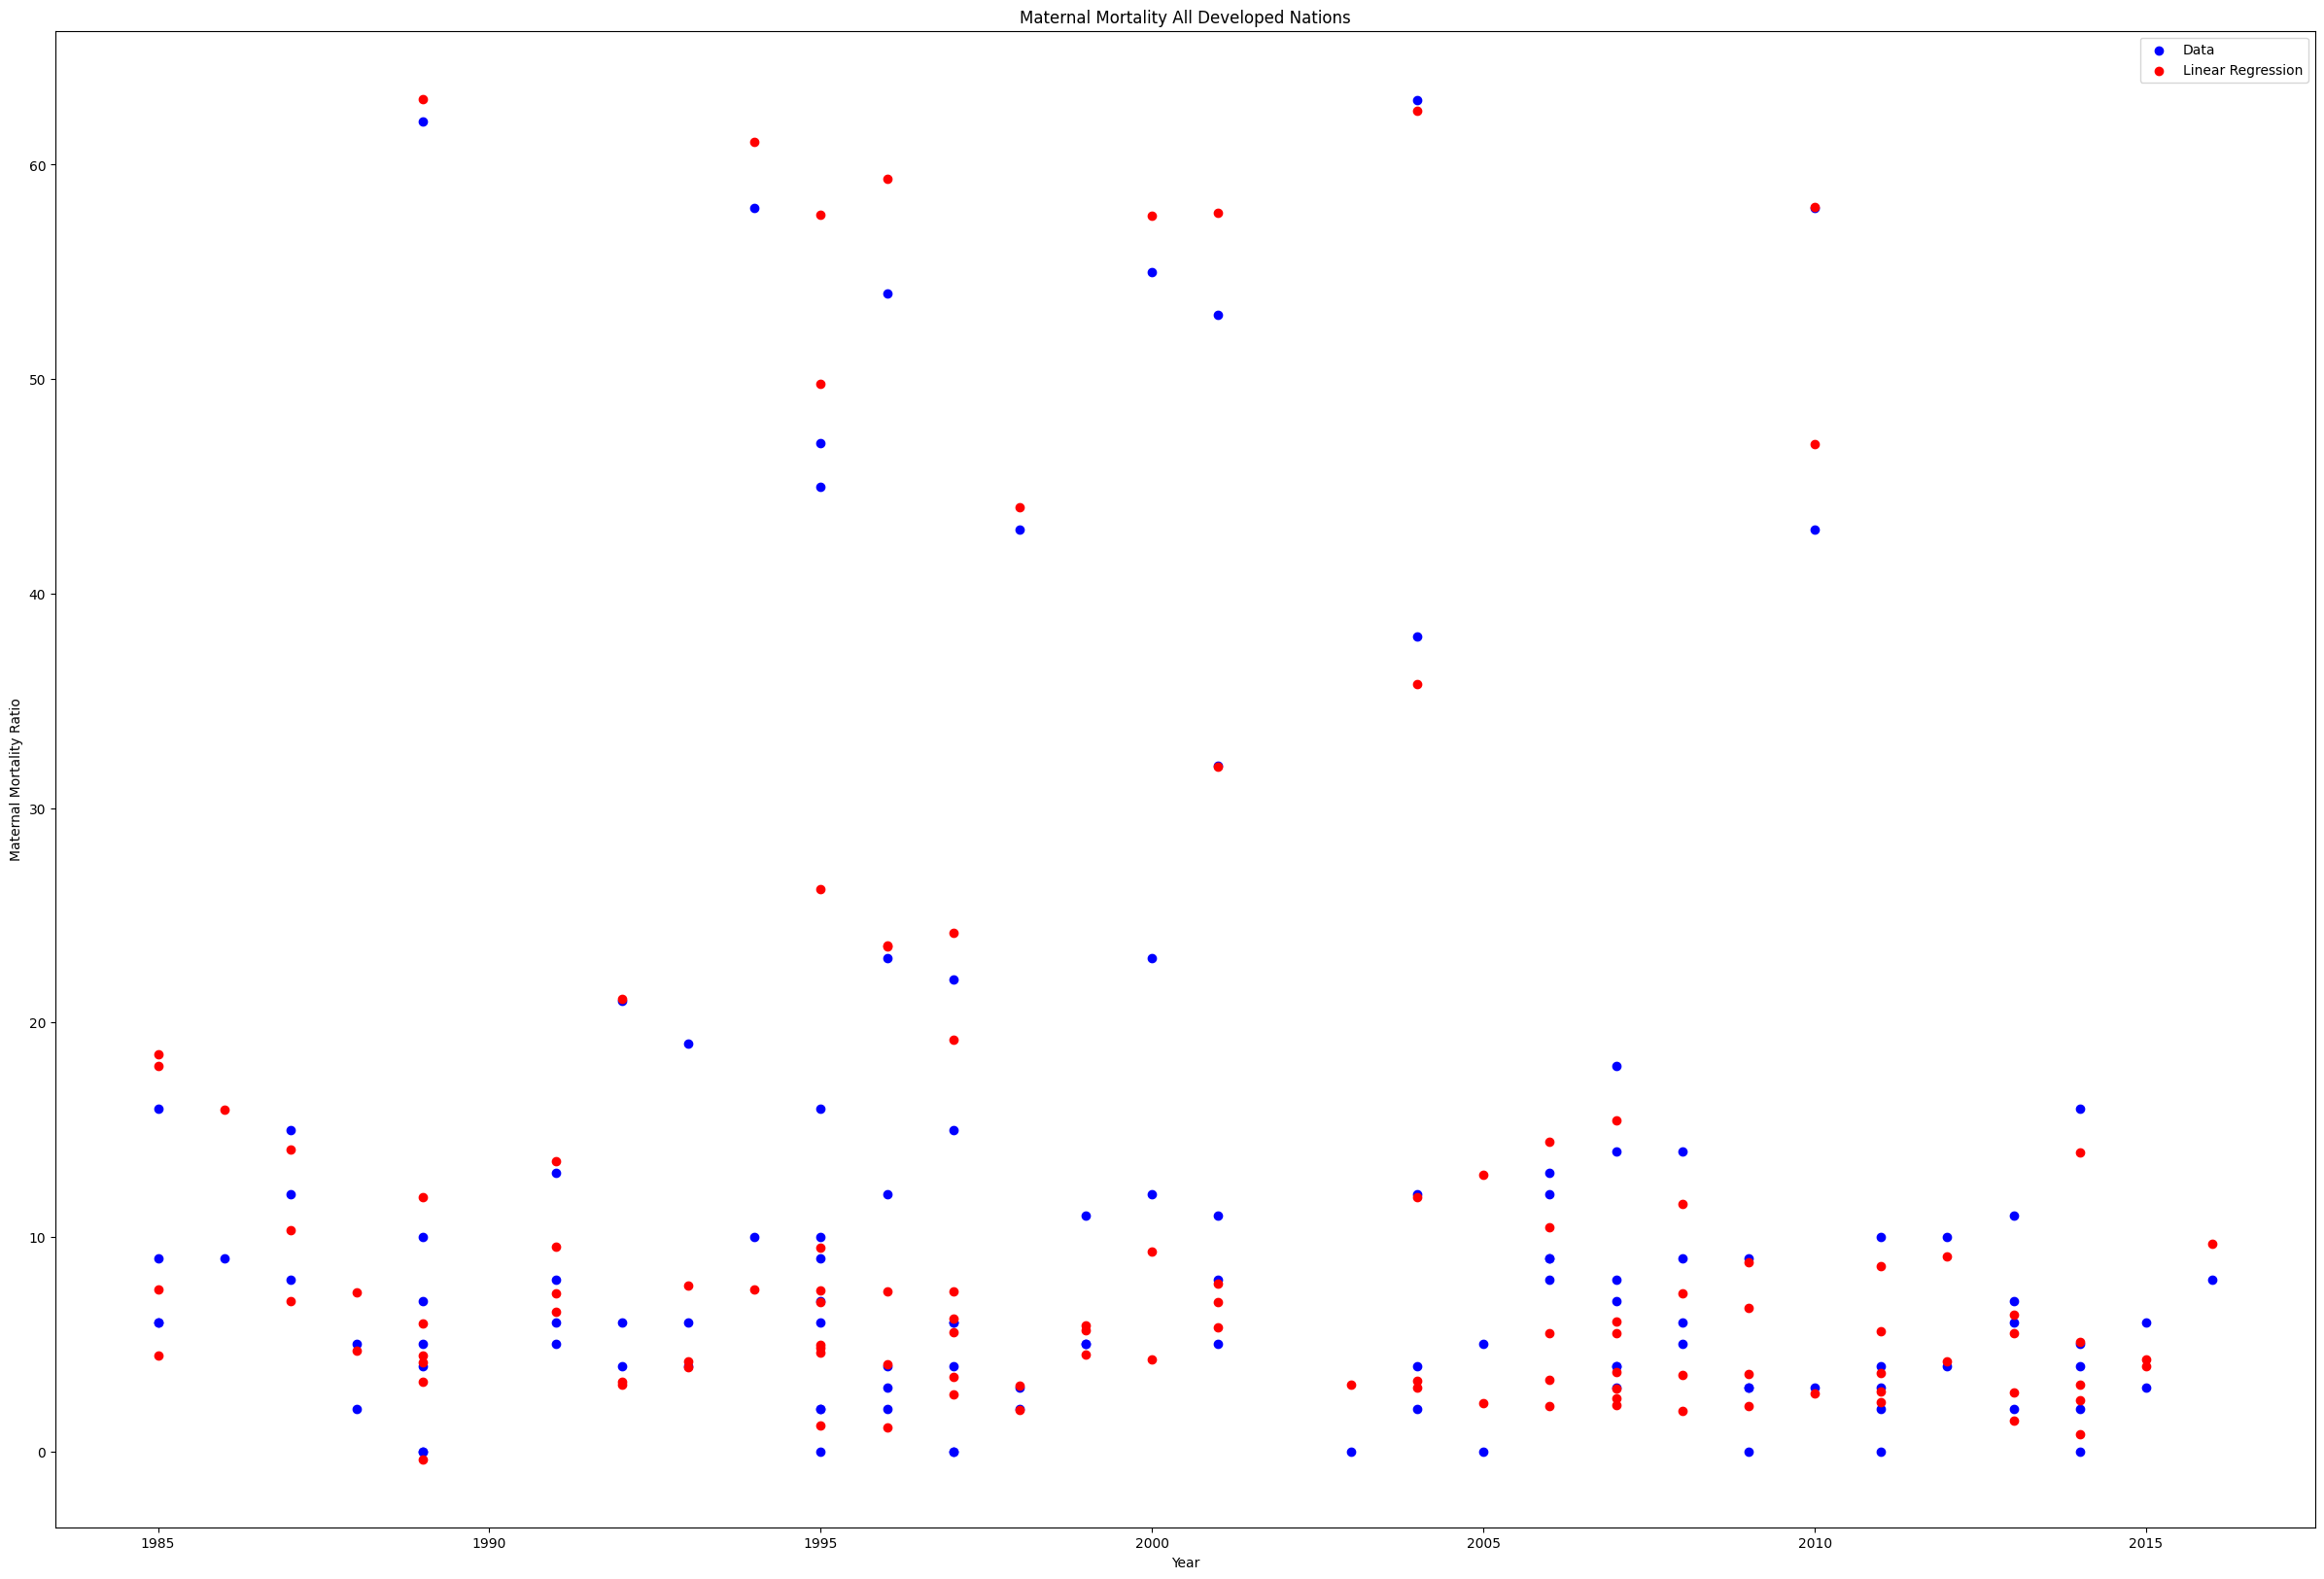

<Figure size 3000x2000 with 0 Axes>

In [189]:
plot_regression(
    X_test,
    y_test,
    y_pred,
    country=None,
    title="Maternal Mortality All Developed Nations",
)

### 5-Fold Cross Validation

In [190]:
tf.keras.utils.set_random_seed(42)

# Create a list to store the mean squared errors (MSE) for each fold
mse_scores = []
r2_scores = []

# Establish best r2 score and best model for returning
best_r2_score = -10000
best_model = None

# Establish model
model = build_model(best_learning_rate, best_num_hidden_units, best_batch_size)
num_epochs = 400

# Create a KFold cross-validator with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-fold cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model on the training data
    history = model.fit(
        X_train, y_train, epochs=num_epochs, batch_size=best_batch_size, verbose=0
    )

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate the mean squared error (MSE) for this fold
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

    # Check if the current model has a higher R2 score
    if r2 > best_r2_score:
        best_r2_score = r2
        best_model = model

        # Save the respective train test split
        X_train_best = X_train
        X_test_best = X_test
        y_train_best = y_train
        y_test_best = y_test

# Calculate the mean and standard deviation of the MSE scores and r2 scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
mean_r2 = np.mean(r2_scores)
std_r2 = np.std(r2_scores)

print(f"Best R-squared (R2): {best_r2_score}")
print(f"Mean R-squared (R2): {mean_r2}")
print(f"Standard Deviation of R-squared (R2): {std_r2}")
print(f"Average Mean Squared Error (MSE): {mean_mse}")
print(f"Standard Deviation of Mean Squared Error (MSE): {std_mse}")

8/8 [==============================] - 0s 1ms/step
Best R-squared (R2): 0.9310299559840486
Mean R-squared (R2): 0.8685864373770279
Standard Deviation of R-squared (R2): 0.037549676333156284
Average Mean Squared Error (MSE): 37.69378661759863
Standard Deviation of Mean Squared Error (MSE): 6.357950122638577


### Look at Outliers - Failure Analysis

In [191]:
# re-establishing the train test split from the best model
X_train = X_train_best
X_test = X_test_best
y_train = y_train_best
y_test = y_test_best
y_pred = best_model.predict(X_test)

8/8 [==============================] - 0s 1ms/step


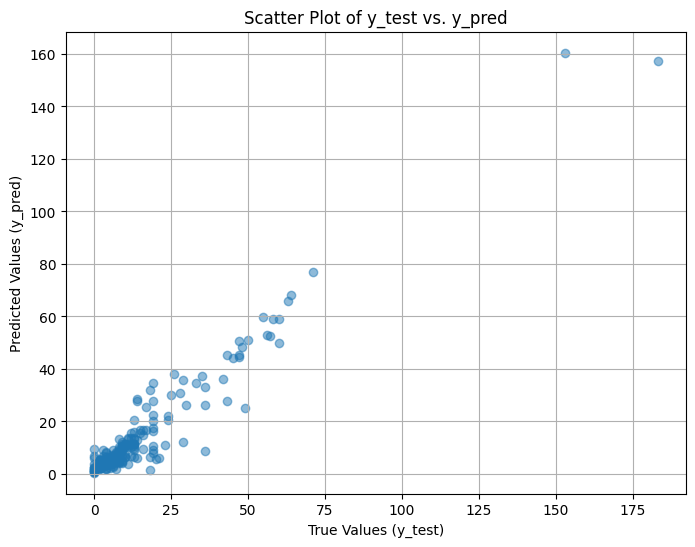

In [192]:
# Create a scatter plot of y_pred vs. y_test
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # alpha adds transparency to the points
plt.title("Scatter Plot of y_test vs. y_pred")
plt.xlabel("True Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.grid(True)
plt.show()